# Caracterización de las señales

In [1]:
#Carga de paquetes 
#Core
import numpy as np
import pandas as pd
import os
from datetime import datetime
import scipy.io
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.fft import fft, fftfreq
from matplotlib import cm
import mat73
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl
import seaborn as sns
sns.set()
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
from numpy import mean
import statistics
from IPython.display import HTML, display_html, display
import mne

In [2]:
%matplotlib qt

In [3]:
## Los 3 puntos contienen una funcion para comparar oclumna a columna los canales

In [4]:
!pip install kedro
from kedro.config import ConfigLoader

def run_describe_feature_comparison(
    column: str,
    Control: pd.DataFrame,
    Parkinson: pd.DataFrame,
) -> pd.DataFrame:

    """
    This function calculates the summary statistics for a column which appears in
    both the real and synthetic data.
    inputs:
        - column name
        - real data
        - synthetic data
    returns:
        - dataframe containing summary statistics
    """

    # Create summary statistics table for synthetic and real datasets
    real_summary = pd.DataFrame(Control[column].describe()).rename(
        columns={column: "Control"}
    )
    syn_summary = pd.DataFrame(Parkinson[column].describe()).rename(
        columns={column: "Parkinson"}
    )

    # concat results together
    df = pd.concat([real_summary, syn_summary], axis=1)

    # take diffenrece if results are not categorical
    try:
        df["difference"] = df["Control"] - df["Parkinson"]
    except:
        pass

    return df


def run_categorical_feature_comparison(
    column: str, Control: pd.DataFrame, Parkinson: pd.DataFrame
) -> str:

    """
    This function runs a summary comparison of categories in the real and synthetic dataset. This includes:
        - counts per category in each dataset
        - proportions of each category in each dataset
    inputs:
        - column name
        - real data
        - synthetic data
    returns:
        - save_image_as_bytes() - the plot is returned as a "utf-8" string so it can be stored in the kedro
        pipline and appear in the html report.
    """

    # Define plots
    fig = plt.figure(figsize=(15, 15))
    ax1 = plt.subplot(2, 2, 1)
    ax2 = plt.subplot(2, 2, 2)
    ax3 = plt.subplot(2, 2, 3)
    ax4 = plt.subplot(2, 2, 4)

    axes = [ax1, ax2, ax3, ax4]

    # Plot categorical counts for real data
    Control[column].value_counts().plot(kind="barh", ax=axes[0])
    axes[0].set_title("Real data counts per category", fontsize=15)
    axes[0].set_ylabel("Count of values", fontsize=10)

    # Plot categorical proportions for real data
    Control[column].value_counts().plot(kind="pie", ax=axes[1], autopct="%1.1f%%")
    axes[1].set_title("Real Data category proportions", fontsize=15)

    # Plot categorical counts for synthetic data
    Parkinson[column].value_counts().plot(kind="barh", ax=axes[2])
    axes[2].set_title("Synthetic Data", fontsize=15)
    axes[2].set_ylabel("Count of values", fontsize=10)

    # Plot categorical proportions for synthetic data
    Parkinson[column].value_counts().plot(
        kind="pie", ax=axes[3], autopct="%1.1f%%"
    )
    axes[3].set_title("Synthetic data category proportions", fontsize=15)

    fig.suptitle(column, fontsize=20)

    # Return plot as "utf-8" string
    return save_image_as_bytes()


def run_numeric_feature_comparison(
    column: str, Control: pd.DataFrame, Parkinson: pd.DataFrame
):

    # Sprint subplots
    Control["Control"] = "Control"
    Parkinson["Control"] = "Parkinson"
    data = pd.concat([Control, Parkinson])

    fig = plt.figure(figsize=(25, 7))
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2)
    ax3 = plt.subplot(1, 3, 3)
    axes = [ax1, ax2, ax3]

    fig.suptitle(column, fontsize=20)

    # Distribution plot comparison
    Control[column].plot.density(color="b", alpha=0.5, ax=axes[0], label="Control")
    Parkinson[column].plot.density(
        color="r", alpha=0.5, ax=axes[0], label="Parkinson"
    )
    axes[0].legend()

    # Boxplot
    sns.boxplot(data=data, x="Control", y=column, ax=axes[1])
    axes[1].legend()

    # Cumulative plot
    Parkinson[column].cumsum().plot(ax=axes[2])
    Control[column].cumsum().plot(ax=axes[2])
    axes[2].legend()
    return save_image_as_bytes()


def run_feature_count_nulls(
    column: str,
    Control: pd.DataFrame,
    Parkinson: pd.DataFrame,
) -> pd.DataFrame:

    real_missing = (Control[column].isna().sum() / len(Control[column])) * 100
    syn_missing = (
        Parkinson[column].isna().sum() / len(Parkinson[column])
    ) * 100
    df = pd.DataFrame(
        {
            "real data % missing": [real_missing],
            "synthetic data % missing": [syn_missing],
        },
    )
    return df


def run_feature_comparison(
    Control: pd.DataFrame, Parkinson: pd.DataFrame, column: str
) -> None:
    """
    This function runs the feature comparison checks for the column specified in the
    dataset and completes the following checks:
    - Runs the description statistic for the column
    - Identifys nulls in the column
    - Runs categorical or numeric feature comparison as specified in the conf/base/parameters file
    """

    # Description statistics
    description = run_describe_feature_comparison(column, Control, Parkinson)
    # Missing values
    nulls = run_feature_count_nulls(column, Control, Parkinson)

    # Load categorical values as defined in conf/base/parameter
    conf_loader = ConfigLoader("conf/base")
    params = conf_loader.get("parameters*", "parameters*/**")

    if column in params["categorical_features"]:
        figure = run_categorical_feature_comparison(column, Control, Parkinson)
    else:
        figure = run_numeric_feature_comparison(column, Control, Parkinson)

    return dict(description=description, nulls=nulls, figure=figure)

In [5]:
#Fix path from home
path = 'C:\\Users\\Vaneza'
os.chdir(path)
os.getcwd()
disco = 'E'

In [3]:
#Fix path from work
path = 'C:\\Users\\Y8764982H\\OneDrive - Generalitat de Catalunya/TFG/'
os.chdir(path)
os.getcwd()
disco = 'D'

In [6]:
#Señales filtradas y recortadas a 2minutos
files_2m = []
for dirname, _, filenames in os.walk('%s:\\TFG\Data and Code (1)\\Dataset\\IowaDataset\\All_tables2\\'%(disco)):
    for filename in filenames:
        if filename.find(".csv") != -1 and not "-checkpoint.csv" in filename:
            files_2m.append(filename)
tables_2m = {p: pd.read_csv('%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\All_tables2\\'%(disco) + p) for p in files_2m}

print(tables_2m.keys())

dict_keys(['all_CT_pat_2m.csv', 'all_PD_pat_2m.csv', 'all_CT_pat_2m_NF.csv', 'all_PD_pat_2m_NF.csv'])


In [31]:
## Canales originales
O_channels = ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9',
       'CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10',
       'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8',
       'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5',
       'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6',
       'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8',
       'AF4', 'F2', 'FCz']

len(O_channels)

63

In [8]:
## Selección de canales
desc = ['Patient','Diagnosis','Time']
Channels = ['Fz', 'FC1', 'C3', 'T7','CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10',
               'CP6', 'CP2', 'Cz', 'C4', 'FC2', 'F1', 'FC3', 'C1', 'C5','TP7', 'CP3', 'P1', 'P5', 'PO7',
               'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2']
len(Channels)

39

In [39]:
CT_Filt = tables_2m['all_CT_pat_2m.csv'][desc + Channels]
CT_NFilt = tables_2m['all_CT_pat_2m_NF.csv'][desc + Channels]
PD_Filt = tables_2m['all_PD_pat_2m.csv'][desc + Channels]
PD_NFilt = tables_2m['all_PD_pat_2m_NF.csv'][desc + Channels]
CT_Filt

,Patient,Diagnosis,Time,Fz,FC1,C3,T7,CP5,CP1,P3,...,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2
0,Control1021,0,15000,49.479165,24.841883,6.792298,1.093104,-8.033309,-1.748609,-9.019939,...,-6.945584,-4.084873,-5.528079,-0.498736,-0.623442,1.556984,6.529484,1.185870,9.194933,17.740672
1,Control1021,0,15002,43.666129,20.031738,3.412564,-0.551348,-9.580822,-2.940870,-9.685697,...,-6.566050,-3.890673,-5.523321,-0.710164,-0.868357,1.519035,6.342097,-0.411366,7.823835,15.794271
2,Control1021,0,15004,37.801224,15.244014,0.090796,-2.042176,-10.816052,-3.678927,-9.667842,...,-5.935424,-3.644903,-5.270600,-0.836859,-0.970631,1.476844,6.225813,-1.502077,7.044750,13.798539
3,Control1021,0,15006,32.325428,11.085431,-2.561522,-3.376300,-11.514968,-3.800149,-8.963480,...,-5.149858,-3.415595,-4.757170,-0.843370,-0.909093,1.506347,6.137558,-1.940335,6.441215,11.988691
4,Control1021,0,15008,27.634802,8.125022,-3.941409,-4.354431,-11.402962,-3.262970,-7.594267,...,-4.259327,-3.220664,-3.976098,-0.732799,-0.714905,1.649932,5.962558,-1.900270,5.344115,10.518710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839995,Control1411,0,124988,-5.658548,-5.609639,-5.527250,-7.299147,-10.404743,-4.275655,-3.800840,...,0.985079,9.582899,5.646106,5.025533,0.036418,-3.821342,3.988778,5.493309,7.634090,-3.442428
839996,Control1411,0,124990,-4.642097,-5.210684,-4.570832,-4.229352,-6.986730,-3.427060,-1.835463,...,1.336392,8.191093,5.537530,5.123648,0.288864,-3.832219,3.834452,5.575962,7.916993,-3.128837
839997,Control1411,0,124992,-3.351458,-4.469692,-3.468410,-0.346857,-2.487947,-2.442150,0.220445,...,1.712653,6.146189,5.174479,4.968358,0.619862,-3.704117,3.813077,5.432633,8.366248,-2.721755
839998,Control1411,0,124994,-2.150082,-3.614138,-2.480248,3.575552,2.089505,-1.587987,2.021660,...,1.958015,4.182032,4.684035,4.660306,0.926075,-3.446358,3.830704,5.124372,8.752647,-2.386502


### Cambio de la columna de tiempo de 0 a 120000

In [40]:
#Creamos el vector de tiempo
rng = np.arange(0.000, 120, 0.002)
rng = pd.DataFrame(rng,columns=['Time'])
#print(rng)
#print(len(rng))
Time_df = rng
for i in range(0,13):
    Time_df = pd.concat([Time_df,rng],axis=0).reset_index(drop=True)
print(Time_df)

#Cambiamos el vector del tiempo de los pacientes de control
CT_F = CT_Filt.copy(deep=True)
CT_NF = CT_NFilt.copy(deep=True)
CT_F['Time'] = Time_df
CT_NF['Time'] = Time_df
print(CT_F)
#print(CT_NF)
#Cambiamos el vector del tiempo de los pacientes de Parkinson
PD_F = PD_Filt.copy(deep=True)
PD_NF = PD_NFilt.copy(deep=True)
PD_F['Time'] = Time_df
PD_NF['Time'] = Time_df
print(PD_F)
#print(PD_NF)

           Time
0         0.000
1         0.002
2         0.004
3         0.006
4         0.008
...         ...
839995  119.990
839996  119.992
839997  119.994
839998  119.996
839999  119.998

[840000 rows x 1 columns]
            Patient  Diagnosis     Time         Fz        FC1        C3  \
0       Control1021          0    0.000  49.479165  24.841883  6.792298   
1       Control1021          0    0.002  43.666129  20.031738  3.412564   
2       Control1021          0    0.004  37.801224  15.244014  0.090796   
3       Control1021          0    0.006  32.325428  11.085431 -2.561522   
4       Control1021          0    0.008  27.634802   8.125022 -3.941409   
...             ...        ...      ...        ...        ...       ...   
839995  Control1411          0  119.990  -5.658548  -5.609639 -5.527250   
839996  Control1411          0  119.992  -4.642097  -5.210684 -4.570832   
839997  Control1411          0  119.994  -3.351458  -4.469692 -3.468410   
839998  Control1411          0 

In [11]:
PD_F['Patient'].unique()

array(['PD1001', 'PD1021', 'PD1031', 'PD1061', 'PD1091', 'PD1101',
       'PD1201', 'PD1251', 'PD1311', 'PD1151', 'PD1261', 'PD1571',
       'PD1661', 'PD1681'], dtype=object)

In [12]:
CT_F

,Patient,Diagnosis,Time,Fz,FC1,C3,T7,CP5,CP1,P3,...,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2
0,Control1021,0,0.000,49.479165,24.841883,6.792298,1.093104,-8.033309,-1.748609,-9.019939,...,-6.945584,-4.084873,-5.528079,-0.498736,-0.623442,1.556984,6.529484,1.185870,9.194933,17.740672
1,Control1021,0,0.002,43.666129,20.031738,3.412564,-0.551348,-9.580822,-2.940870,-9.685697,...,-6.566050,-3.890673,-5.523321,-0.710164,-0.868357,1.519035,6.342097,-0.411366,7.823835,15.794271
2,Control1021,0,0.004,37.801224,15.244014,0.090796,-2.042176,-10.816052,-3.678927,-9.667842,...,-5.935424,-3.644903,-5.270600,-0.836859,-0.970631,1.476844,6.225813,-1.502077,7.044750,13.798539
3,Control1021,0,0.006,32.325428,11.085431,-2.561522,-3.376300,-11.514968,-3.800149,-8.963480,...,-5.149858,-3.415595,-4.757170,-0.843370,-0.909093,1.506347,6.137558,-1.940335,6.441215,11.988691
4,Control1021,0,0.008,27.634802,8.125022,-3.941409,-4.354431,-11.402962,-3.262970,-7.594267,...,-4.259327,-3.220664,-3.976098,-0.732799,-0.714905,1.649932,5.962558,-1.900270,5.344115,10.518710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839995,Control1411,0,119.990,-5.658548,-5.609639,-5.527250,-7.299147,-10.404743,-4.275655,-3.800840,...,0.985079,9.582899,5.646106,5.025533,0.036418,-3.821342,3.988778,5.493309,7.634090,-3.442428
839996,Control1411,0,119.992,-4.642097,-5.210684,-4.570832,-4.229352,-6.986730,-3.427060,-1.835463,...,1.336392,8.191093,5.537530,5.123648,0.288864,-3.832219,3.834452,5.575962,7.916993,-3.128837
839997,Control1411,0,119.994,-3.351458,-4.469692,-3.468410,-0.346857,-2.487947,-2.442150,0.220445,...,1.712653,6.146189,5.174479,4.968358,0.619862,-3.704117,3.813077,5.432633,8.366248,-2.721755
839998,Control1411,0,119.996,-2.150082,-3.614138,-2.480248,3.575552,2.089505,-1.587987,2.021660,...,1.958015,4.182032,4.684035,4.660306,0.926075,-3.446358,3.830704,5.124372,8.752647,-2.386502


#### Comprobación Visual FFT y Grafica

In [13]:
#Función que organiza los datos tubulares para que funcionen adecuadamente en la el análisis
def get_record_df(df): 
    df_record = df
    df_record = df_record.drop(columns = desc)
    df_record = df_record.T
    return df_record.to_numpy()

In [47]:
## Plot of CT patients 
fig, [sig1,sig2]  = plt.subplots(2,1,figsize=(10,4))
signal = CT_F[(CT_F["Patient"] == "Control1021")].reset_index(drop=True)
sig1.plot(signal["Time"], signal['Fz'], label='CT Fz')
sig1.set_title('Paciente de Control 0 - Canal Fz')
sig1.legend(loc='upper right')
sig1.set_ylabel("Amplitud")
sig1.set_xlabel("Tiempo(s)")
sig1.set_xlim(0,120)

## Plot of PD patients 

signal_PD = PD_F[(PD_F["Patient"] == "PD1001")].reset_index(drop=True)
sig2.plot(signal_PD["Time"], signal_PD['Fz'], label='PD Fz')
sig2.set_title('Paciente de Párkinson 0 - Canal Fz')
sig2.legend(loc='upper right')
sig2.set_ylabel("Amplitud")
sig2.set_xlabel("Tiempo(s)")
sig2.set_xlim(0,120)

(0.0, 120.0)

In [49]:
signal = CT_F[(CT_F["Patient"] == "Control1021")].reset_index(drop=True)
signal_array = get_record_df(signal)
print(signal_array.shape)
print(len(signal))
print('signal array:', signal_array)

(42, 60000)
60000
signal array: [['Control1021' 'Control1021' 'Control1021' ... 'Control1021'
  'Control1021' 'Control1021']
 [0 0 0 ... 0 0 0]
 [0.0 0.002 0.004 ... 119.994 119.99600000000001 119.998]
 ...
 [1.1858701588171114 -0.4113656897482631 -1.5020774700068604 ...
  1.0891596230214926 1.10620509885019 1.111164575270581]
 [9.194932944737324 7.823834662233925 7.04474979063074 ...
  -4.126972539981047 -3.3765394757121348 -2.629373295860637]
 [17.740671566373017 15.79427145061482 13.798538546476571 ...
  -8.149750762760686 -7.706536881799093 -6.94296806960558]]


In [13]:
PD_F['Patient'].unique()

array(['PD1001', 'PD1021', 'PD1031', 'PD1061', 'PD1091', 'PD1101',
       'PD1201', 'PD1251', 'PD1311', 'PD1151', 'PD1261', 'PD1571',
       'PD1661', 'PD1681'], dtype=object)

In [52]:
signal_array_PD = get_record_df(signal_PD)
print(signal_array_PD.shape)
print(len(signal_PD))
print('signal array:', signal_array_PD)

(42, 60000)
60000
signal array: [['PD1001' 'PD1001' 'PD1001' ... 'PD1001' 'PD1001' 'PD1001']
 [1 1 1 ... 1 1 1]
 [0.0 0.002 0.004 ... 119.994 119.99600000000001 119.998]
 ...
 [-0.9453676404815504 -0.6948661702293317 -0.5406823153634287 ...
  7.491597663953155 1.3321324337609224 -3.92197827381178]
 [-0.7992737713546245 -1.329777815838321 -1.1188854955857872 ...
  -0.824596633723027 -4.113940493554793 -5.74796708344058]
 [-0.7479110793762378 -2.991693018085713 -5.662232923667429 ...
  -9.315805028343489 -11.339422767504134 -13.199914081750176]]


In [56]:
# Number of samples in normalized_tone
fig, [[ax1,ax2],[ax3,ax4]]  = plt.subplots(2,2,figsize=(10,4))
SAMPLE_RATE = 500 #Hz
DURATION = len(signal)


N = DURATION

yf = fft(signal_array[9])
xf = fftfreq(N, 1 / SAMPLE_RATE)

ax1.plot(xf, np.abs(yf))
ax1.set_title('FFT Filtrada - Paciente: Control 0 - Canal Fz')
ax1.set_xlabel('Frecuencia (Hz)')
ax1.set_ylabel('Amplitud')

from scipy.fft import rfft, rfftfreq

# Note the extra 'r' at the front
yfft = rfft(signal_array[9])
xfft = rfftfreq(N, 1 / SAMPLE_RATE)

ax2.plot(xfft, np.abs(yfft))
ax2.set_title('FFT rápida Filtrada - Paciente: Control 0 - Canal Fz')
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('Amplitud')

# Number of samples in normalized_tone
#fig, [ax1,ax2]  = plt.subplots(1,2,figsize=(10,4))
SAMPLE_RATE = 500 #Hz
DURATION = len(signal_PD)


N = DURATION

yf = fft(signal_array_PD[9])
xf = fftfreq(N, 1 / SAMPLE_RATE)

ax3.plot(xf, np.abs(yf))
ax3.set_title('FFT Filtrada - Paciente: Párkinson 0 - Canal Fz')
ax3.set_xlabel('Frecuencia (Hz)')
ax3.set_ylabel('Amplitud')

from scipy.fft import rfft, rfftfreq

# Note the extra 'r' at the front
yfft = rfft(signal_array_PD[9])
xfft = rfftfreq(N, 1 / SAMPLE_RATE)

ax4.plot(xfft, np.abs(yfft))
ax4.set_title('FFT rápida Filtrada - Paciente: Párkinson 0 - Canal Fz')
ax4.set_xlabel('Frecuencia (Hz)')
ax4.set_ylabel('Amplitud')
 

Text(0, 0.5, 'Amplitud')

## Plot de todos los canales con mne en control y parkinson

In [41]:
#Función que organiza los datos tubulares para que funcionen adecuadamente en la el análisis
def get_record_df(df): #Write 0 for control and 1 for PD
    signal_array = df.T
    return signal_array.to_numpy()

def plot_all_channels(Signal,Patient):
    test_signal = Signal[(Signal["Patient"] == Patient)].reset_index(drop=True)
    test_signal = test_signal[Channels]

    NF_signal_array = get_record_df(test_signal)

    #Load signal data to an MNE Raw object
    NF_info = mne.create_info(ch_names=Channels, sfreq=500, ch_types=['eeg']*39)
    NF_raw = mne.io.RawArray(NF_signal_array, NF_info)

    NF_standard_1020_montage = mne.channels.make_standard_montage('standard_1020');
    NF_raw.set_montage(NF_standard_1020_montage)

    F_raw = NF_raw.copy()

    events = mne.make_fixed_length_events(F_raw, start=0, stop=10, duration=1., overlap=0.5)

    epochs = mne.Epochs(F_raw, events, preload=True).pick_types(eeg=True)

    # we'll try to keep a consistent ylim across figures
    #plot_kwargs = dict(picks='all', ylim=dict(eeg=(-35000000, 35000000)))
    plot_kwargs = dict(picks='all')
    # plot the evoked for the EEG and the EOG sensors
    fig = epochs.average('all').plot(**plot_kwargs)
    #fig.set_size_inches(18.5, 10.5, forward=True)
    #plt.show()

In [43]:
plot_all_channels(CT_F,'Control1191')

Creating RawArray with float64 data, n_channels=39, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.
Not setting metadata
19 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 19 events and 351 original time points ...
1 bad epochs dropped


In [3]:
Control_names = ['Control1021', 'Control1041', 'Control1061', 'Control1081',
                 'Control1101', 'Control1111', 'Control1191', 'Control1201',
                 'Control1211', 'Control1231', 'Control1381', 'Control1291',
                 'Control1351', 'Control1411']

Parkinson_names = ['PD1001', 'PD1021', 'PD1031', 'PD1061', 'PD1091', 'PD1101',
                   'PD1201', 'PD1251', 'PD1311', 'PD1151', 'PD1261', 'PD1571',
                   'PD1661', 'PD1681']

signals = [CT_F,CT_NF,PD_F,PD_NF]

CT_plots = []

n=0
for i in Parkinson_names:
    plot_all_channels(PD_F,i)
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_CT_PD_allChannels\\PD_%s_allCH_av.jpg"%(disco,n))
    n=n+1
    
        

NameError: name 'CT_F' is not defined

# CARACTERIZACIÓN EN TIEMPO

## .describe()

In [14]:
#Función que organiza los datos tubulares para que funcionen adecuadamente en la el análisis
def get_record_df(df): #Write 0 for control and 1 for PD
    signal_array = df.T
    return signal_array.to_numpy()

In [95]:
CT_F.describe()

,Diagnosis,Time,Fz,FC1,C3,T7,CP5,CP1,P3,P7,...,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2
count,840000.0,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,...,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000
mean,0.0,59.999000,-0.013675,-0.007066,-0.001743,0.008330,0.004800,0.000197,0.002819,0.006359,...,0.002791,0.008054,0.005023,0.002910,-0.000348,-0.000251,0.000614,0.003508,0.007217,-0.008362
std,0.0,34.641037,11.786810,8.571017,7.215764,8.356696,6.292165,4.553203,3.934889,5.465122,...,3.599087,6.285209,5.289226,4.796609,2.129930,4.130696,5.497291,6.991056,7.847077,6.270181
min,0.0,0.000000,-157.186158,-138.475954,-315.305658,-144.889171,-94.097210,-60.423775,-41.054337,-58.573197,...,-62.994769,-77.302532,-76.994760,-38.235808,-48.179873,-35.692408,-131.759155,-123.839865,-172.852217,-164.576073
25%,0.0,29.999500,-5.199557,-4.296186,-3.776933,-4.227942,-3.195311,-2.452893,-1.788226,-2.473272,...,-1.186205,-2.731861,-2.427505,-2.169508,-0.715130,-2.026785,-2.931101,-3.509837,-4.041999,-3.263213
50%,0.0,59.999000,0.091579,0.038749,0.032637,-0.001959,0.005208,0.017664,-0.007068,-0.012044,...,-0.006742,-0.017283,-0.006508,0.007919,0.005610,0.012269,0.019995,-0.007111,0.017220,0.026312
75%,0.0,89.998500,5.348134,4.338227,3.805841,4.229248,3.196540,2.490698,1.772621,2.458476,...,1.160311,2.653128,2.406445,2.167725,0.731656,2.074134,2.981925,3.531746,4.101025,3.327957
max,0.0,119.998000,127.584210,119.683129,227.203809,137.946600,88.612613,46.576822,58.776939,83.496043,...,94.775836,119.735633,95.398394,50.448172,22.516583,40.733384,133.995553,160.816950,186.298711,146.000335


In [15]:
CT_F_array = CT_F.copy().drop(columns=['Patient','Time','Diagnosis'])
PD_F_array = PD_F.copy().drop(columns=['Patient','Time','Diagnosis'])
pre_data_CT = get_record_df(CT_F_array)
data_CT = []
pre_data_PD = get_record_df(PD_F_array)
data_PD = []
xticks = []
for i in range(0,39):
    data_CT.append(pre_data_CT[i])
    data_PD.append(pre_data_PD[i])
    xticks.append(i+1)

In [43]:
xticks

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

In [18]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10,30))

red_square = dict(markerfacecolor='r', marker='s')
ax1.boxplot(data_CT, vert=False,notch=True,flierprops=red_square)
ax1.set_title('Pacientes de Control - 39 Canales')
ax1.set_yticks(xticks,Channels)


ax2.boxplot(data_PD, vert=False,notch=True,flierprops=red_square)
ax2.set_title('Pacientes de Párkinson - 39 Canales')
ax2.set_yticks(xticks,Channels)

plt.show()

In [19]:
desc_CT = CT_F_array.describe()
descT_CT = desc_CT.T
percentiles_CT = descT_CT[['25%','50%','75%']]
med_desv_CT = descT_CT[['mean','std','min','max']]

desc_PD = PD_F_array.describe()
descT_PD = desc_PD.T
percentiles_PD = descT_PD[['25%','50%','75%']]
med_desv_PD = descT_PD[['mean','std','min','max']]

percentiles_CT
percentiles_PD

,25%,50%,75%
Fz,-6.573518,-0.035794,6.504181
FC1,-5.331506,-0.015674,5.299604
C3,-4.735501,0.002721,4.668737
T7,-6.570280,0.088844,6.593328
CP5,-4.280896,0.049688,4.349049
CP1,-2.163630,0.005291,2.146977
P3,-1.427927,0.017509,1.490659
P7,-2.497874,0.020913,2.525329
O1,-3.612409,-0.005526,3.627711
Oz,-3.352288,-0.006235,3.313184


In [101]:
med_desv_PD.to_csv("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\med_desv_PD.csv"%(disco),index=True)

In [27]:
med_desv_PD.T

,Fz,FC1,C3,T7,CP5,CP1,P3,P7,O1,Oz,...,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2
mean,0.007549,0.005356,0.004707,0.002773,0.002091,0.001231,0.000913,0.000192,0.000765,0.000518,...,0.001431,-0.000194,0.003227,0.002389,-0.000448,0.000976,-0.001121,0.001792,0.005795,-0.000554
std,12.689722,9.818037,8.545181,11.729521,8.303078,4.557533,5.197646,7.559120,8.067222,8.394297,...,5.563354,9.224212,8.839668,7.051270,3.948008,3.619828,6.672486,10.275690,9.852011,8.594974
min,-116.606296,-58.446956,-74.626103,-100.957430,-64.228179,-43.652046,-63.910900,-75.062223,-70.049369,-77.835278,...,-45.382279,-68.907663,-78.163770,-54.391454,-62.368414,-29.429033,-77.047462,-74.790338,-132.577690,-62.935028
max,120.476026,67.622960,60.219207,81.537686,65.960621,32.280886,44.313574,61.275841,76.238024,67.893414,...,43.717952,82.869165,71.373592,52.503257,29.941692,36.713580,56.051266,78.111849,100.073057,61.408365


In [20]:
pre_percentiles_CT = get_record_df(percentiles_CT)
pre_percentiles_PD = get_record_df(percentiles_PD)
percentiles_CT_data = []
percentiles_PD_data = []
xticks = []
for i in range(0,3):
    percentiles_CT_data.append(pre_percentiles_CT[i])
    percentiles_PD_data.append(pre_percentiles_PD[i])
    xticks.append(i+1)
    
percentiles_CT_data
percentiles_PD_data

[array([-6.57351781, -5.33150575, -4.73550132, -6.57028016, -4.28089586,
        -2.16363009, -1.42792712, -2.49787377, -3.61240907, -3.35228815,
        -3.17129152, -2.45604767, -3.087936  , -7.15853386, -4.14341953,
        -3.21196007, -3.67144074, -4.94299093, -5.69554759, -6.45362566,
        -5.89024354, -4.30779501, -5.94963327, -5.60455129, -3.31808137,
        -0.83182395, -2.31993303, -3.64823719, -3.54578399, -1.68348359,
        -4.23231876, -3.990957  , -2.75534825, -1.1793404 , -1.1393424 ,
        -3.62914674, -5.3705499 , -5.70134307, -4.5023219 ]),
 array([-0.03579411, -0.01567382,  0.00272123,  0.08884428,  0.04968766,
         0.0052911 ,  0.01750917,  0.0209126 , -0.00552648, -0.00623484,
        -0.00136098,  0.00367338, -0.00367929,  0.0327835 ,  0.00432708,
        -0.01164088, -0.02493683, -0.01427266, -0.04714873, -0.01276248,
        -0.01822532, -0.00929548,  0.05090493,  0.07182212,  0.04257062,
         0.00072391,  0.02335446,  0.00028828, -0.02089737,  0

In [21]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(10,10))

red_square = dict(markerfacecolor='r', marker='s')
ax1.boxplot(percentiles_CT_data,notch=True,flierprops=red_square)
ax1.set_title('Percentiles de 25%,50%,75% - 39 Canales - Control')
ax1.set_xticks(xticks,['25%','50%','75%'])
ax1.set_ylim(-6,6)

red_square = dict(markerfacecolor='r', marker='s')
ax2.boxplot(percentiles_PD_data,notch=True,flierprops=red_square)
ax2.set_title('Percentiles de 25%,50%,75% - 39 Canales - Párkinson')
ax2.set_xticks(xticks,['25%','50%','75%'])
ax2.set_ylim(-6,6)

plt.show()

In [59]:
fig = plt.figure(figsize=(10,10))

red_square = dict(markerfacecolor='r', marker='s')
plt.boxplot(percentiles_PD_data,notch=True,flierprops=red_square)
plt.title('Percentiles de 25%,50%,75% - 39 Canales - Párkinson')
plt.xticks(xticks,['25%','50%','75%'])
plt.show()

In [71]:
CT_NF.describe()

,Diagnosis,Time,Fz,FC1,C3,T7,CP5,CP1,P3,P7,...,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2
count,840000.0,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,...,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000
mean,0.0,59.999000,1.069580,0.613579,0.664460,-0.048873,1.632386,-0.841339,-1.057732,0.027131,...,0.583350,0.193200,0.318689,-0.319231,0.260646,-0.058648,0.530792,0.625525,1.375455,0.285254
std,0.0,34.641037,24.914984,21.627776,21.819733,30.411186,23.749231,14.893731,18.278499,16.865589,...,19.405595,20.330520,15.571635,15.830532,7.658949,13.785463,18.669622,20.405131,26.216814,21.138815
min,0.0,0.000000,-277.664300,-353.932980,-671.842600,-546.453100,-336.272950,-138.488530,-170.400470,-176.125440,...,-170.986820,-230.840560,-171.882420,-147.968460,-71.939690,-115.585940,-336.016240,-350.930570,-572.378100,-574.488100
25%,0.0,29.999500,-11.929514,-9.867124,-9.987804,-13.389774,-9.379758,-7.832798,-7.082676,-7.068855,...,-4.408461,-7.965780,-6.517635,-7.388237,-3.067169,-6.721106,-8.506941,-9.583068,-11.189542,-9.812125
50%,0.0,59.999000,-0.971902,-0.944694,-0.822553,-0.006507,-0.680191,-0.994351,-0.794045,-0.379735,...,-0.276312,-0.179228,-0.001859,-0.441542,0.125572,-0.367137,0.409374,0.105340,0.193301,-0.646845
75%,0.0,89.998500,11.008560,9.191209,9.768387,14.487242,9.833495,6.241691,5.090888,5.978629,...,4.006195,7.403429,7.017444,5.997970,3.225087,6.047546,9.174902,9.900650,12.318509,8.616315
max,0.0,119.998000,217.035700,321.965330,817.150400,327.776200,304.849700,169.990420,135.249190,157.236270,...,157.881800,201.877780,173.189710,131.976200,65.850110,85.799126,311.534200,313.347660,349.474120,385.387940


In [72]:
PD_F.describe()

,Diagnosis,Time,Fz,FC1,C3,T7,CP5,CP1,P3,P7,...,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2
count,840000.0,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,...,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000
mean,1.0,59.999000,0.007549,0.005356,0.004707,0.002773,0.002091,0.001231,0.000913,0.000192,...,0.001431,-0.000194,0.003227,0.002389,-0.000448,0.000976,-0.001121,0.001792,0.005795,-0.000554
std,0.0,34.641037,12.689722,9.818037,8.545181,11.729521,8.303078,4.557533,5.197646,7.559120,...,5.563354,9.224212,8.839668,7.051270,3.948008,3.619828,6.672486,10.275690,9.852011,8.594974
min,1.0,0.000000,-116.606296,-58.446956,-74.626103,-100.957430,-64.228179,-43.652046,-63.910900,-75.062223,...,-45.382279,-68.907663,-78.163770,-54.391454,-62.368414,-29.429033,-77.047462,-74.790338,-132.577690,-62.935028
25%,1.0,29.999500,-6.573518,-5.331506,-4.735501,-6.570280,-4.280896,-2.163630,-1.427927,-2.497874,...,-1.683484,-4.232319,-3.990957,-2.755348,-1.179340,-1.139342,-3.629147,-5.370550,-5.701343,-4.502322
50%,1.0,59.999000,-0.035794,-0.015674,0.002721,0.088844,0.049688,0.005291,0.017509,0.020913,...,0.002222,-0.032486,-0.005102,0.003435,0.006637,-0.002368,0.008919,0.012550,0.000156,-0.024006
75%,1.0,89.998500,6.504181,5.299604,4.668737,6.593328,4.349049,2.146977,1.490659,2.525329,...,1.699340,4.133375,3.958519,2.737613,1.191034,1.125059,3.620761,5.290537,5.622162,4.435137
max,1.0,119.998000,120.476026,67.622960,60.219207,81.537686,65.960621,32.280886,44.313574,61.275841,...,43.717952,82.869165,71.373592,52.503257,29.941692,36.713580,56.051266,78.111849,100.073057,61.408365


In [73]:
PD_NF.describe()

,Diagnosis,Time,Fz,FC1,C3,T7,CP5,CP1,P3,P7,...,POz,PO4,PO8,P6,P2,CPz,CP4,TP8,C6,C2
count,840000.0,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,...,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000,840000.000000
mean,1.0,59.999000,1.943322,1.526401,-0.102703,-1.145737,-1.440561,1.040530,-1.289023,-1.334630,...,4.074513,0.430234,-1.247334,-1.793912,1.108463,0.375464,1.387176,-2.712378,1.036164,1.311536
std,0.0,34.641037,38.821810,42.296729,33.090024,51.069974,43.961303,37.108844,39.082632,38.403745,...,40.358492,62.294722,48.955153,44.663564,14.851598,28.131745,37.875679,45.723221,48.155098,32.931525
min,1.0,0.000000,-252.509450,-283.648680,-207.757580,-326.868200,-324.226400,-238.442800,-278.091640,-294.407600,...,-142.796970,-506.025760,-335.216250,-326.551800,-86.406070,-175.109900,-299.954770,-423.047450,-357.577270,-266.552500
25%,1.0,29.999500,-13.622069,-10.313276,-12.513340,-18.717780,-13.060095,-6.978911,-6.016919,-7.651336,...,-7.126990,-14.211292,-13.245929,-8.389322,-4.746785,-5.471603,-10.168465,-14.192261,-13.952720,-11.533901
50%,1.0,59.999000,1.151177,1.209815,-0.091924,-2.040087,-0.384108,-0.277658,-0.487910,-0.650403,...,-0.587661,-1.005332,-1.002497,-0.804772,0.218692,0.005881,0.133618,-0.317449,0.897982,0.597752
75%,1.0,89.998500,15.518842,13.588698,11.644285,16.641596,11.182407,7.692135,3.274308,5.735453,...,7.709641,12.746647,10.004401,7.685732,5.414618,6.194801,10.376814,13.013169,15.528185,12.454700
max,1.0,119.998000,357.611850,499.632400,343.361570,429.463350,347.330320,376.886320,423.038850,435.740020,...,356.206400,456.336700,491.336760,414.842530,95.281660,275.734100,404.990420,478.133820,533.760700,255.531510


In [17]:
!pip install kedro
from kedro.config import ConfigLoader

def run_describe_feature_comparison(
    column: str,
    Control: pd.DataFrame,
    Parkinson: pd.DataFrame,
) -> pd.DataFrame:

    """
    This function calculates the summary statistics for a column which appears in
    both the real and synthetic data.
    inputs:
        - column name
        - real data
        - synthetic data
    returns:
        - dataframe containing summary statistics
    """

    # Create summary statistics table for synthetic and real datasets
    real_summary = pd.DataFrame(Control[column].describe()).rename(
        columns={column: "Control"}
    )
    syn_summary = pd.DataFrame(Parkinson[column].describe()).rename(
        columns={column: "Parkinson"}
    )

    # concat results together
    df = pd.concat([real_summary, syn_summary], axis=1)

    # take diffenrece if results are not categorical
    try:
        df["difference"] = df["Control"] - df["Parkinson"]
    except:
        pass

    return df

In [74]:
CH = ['Fz', 'FC1', 'C3', 'T7','CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10',
       'CP6', 'CP2', 'Cz', 'C4', 'FC2', 'F1', 'FC3', 'C1', 'C5','TP7', 'CP3', 'P1', 'P5', 'PO7',
       'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2']

In [75]:
run_describe_feature_comparison(CH[0], CT_F, PD_F)

NameError: name 'run_describe_feature_comparison' is not defined

In [208]:
run_describe_feature_comparison(CH[0], CT_NF, PD_NF)

,Control,Parkinson,difference
count,840000.000000,840000.000000,0.000000
mean,1.069580,1.943322,-0.873742
std,24.914984,38.821810,-13.906826
min,-277.664300,-252.509450,-25.154850
25%,-11.929514,-13.622069,1.692555
50%,-0.971902,1.151177,-2.123080
75%,11.008560,15.518842,-4.510282
max,217.035700,357.611850,-140.576150


## .entropy

In [30]:
pip install entropy

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for entropy: filename=entropy-0.1.5-py3-none-any.whl size=7191 sha256=449090f68bce4a060e818f41736b3c623e6d0298ac08d82510999b27ada624c9
  Stored in directory: c:\users\vaneza\appdata\local\pip\cache\wheels\ca\6a\c1\d063807fe69f41febfdd55f8f17624428237df5b4001d916e3
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=ccf768d7d28b25235eb55b04cc31ff87c16c458ee48d69e2915a3703b29c8439
  Stored in directory: c:\users\vaneza\appdata\local\pip\cache\wheels\70\4a\46\1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built entropy docopt
Note: you may need to restart the kernel to use updated packages.


In [31]:
"""Entropy functions"""
import entropy as ent
from numba import jit
from math import factorial, log
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch


In [32]:
def spectral_entropy(x, sf, method='fft', nperseg=None, normalize=False,
                     axis=-1):
   
    x = np.asarray(x)
    # Compute and normalize power spectrum
    if method == 'fft':
        _, psd = periodogram(x, sf, axis=axis)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg, axis=axis)
    psd_norm = psd / psd.sum(axis=axis, keepdims=True)
    se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)
    if normalize:
        se /= np.log2(psd_norm.shape[axis])
    return se


In [51]:
Control_names = ['Control1021', 'Control1041', 'Control1061', 'Control1081',
                 'Control1101', 'Control1111', 'Control1191', 'Control1201',
                 'Control1211', 'Control1231', 'Control1381', 'Control1291',
                 'Control1351', 'Control1411']

Parkinson_names = ['PD1001', 'PD1021', 'PD1031', 'PD1061', 'PD1091', 'PD1101',
                   'PD1201', 'PD1251', 'PD1311', 'PD1151', 'PD1261', 'PD1571',
                   'PD1661', 'PD1681']

CH = ['Fz', 'FC1', 'C3', 'T7','CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10',
       'CP6', 'CP2', 'Cz', 'C4', 'FC2', 'F1', 'FC3', 'C1', 'C5','TP7', 'CP3', 'P1', 'P5', 'PO7',
       'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2']

CH_df = pd.DataFrame(CH,columns = ['Channels'])

##--------------------------------------------------------------------------------------------------
for n in range(0,14):
    Channels_entropy_CT = []
    signal_CT = CT_F[(CT_F["Patient"] == Control_names[n])].drop(columns=['Patient','Time','Diagnosis']).reset_index(drop=True)
    signal_array_CT = get_record_df(signal_CT)
    for i in range(0,39):
        se = spectral_entropy(signal_array_CT[i], 500, method='fft',normalize=True)
        Channels_entropy_CT.append(se)
    if (n == 0):
        CH_e = pd.DataFrame(Channels_entropy_CT,columns=['se_CT%s'%(n)])
    else:
        CH_e2 = pd.DataFrame(Channels_entropy_CT,columns=['se_CT%s'%(n)])
        CH_e = pd.concat([CH_e,CH_e2],axis=1).reset_index(drop=True)

CH_e = pd.concat([CH_df,CH_e],axis=1).reset_index(drop=True)

##--------------------------------------------------------------------------------------------------    
for m in range(0,14):
    Channels_entropy_PD = []
    signal_PD = PD_F[(PD_F["Patient"] == Parkinson_names[m])].drop(columns=['Patient','Time','Diagnosis']).reset_index(drop=True)
    signal_array_PD = get_record_df(signal_PD)
    for l in range(0,39):
        se = spectral_entropy(signal_array_PD[l], 500, method='fft',normalize=True)
        Channels_entropy_PD.append(se)
    if (m == 0):
        CH_e_pd = pd.DataFrame(Channels_entropy_PD,columns=['se_PD%s'%(m)])
    else:
        CH_e2_pd = pd.DataFrame(Channels_entropy_PD,columns=['se_PD%s'%(m)])
        CH_e_pd = pd.concat([CH_e_pd,CH_e2_pd],axis=1).reset_index(drop=True)

CH_e_PD = pd.concat([CH_df,CH_e_pd],axis=1).reset_index(drop=True)

##--------------------------------------------------------------------------------------------------
#Mean spectral entropy of CT patients (channel by channel) ª (all channels)
CH_e_T = CH_e.T
CH_e_T.columns = CH_e_T.iloc[0]
CH_e_T = CH_e_T.drop(CH_e_T.index[0])
#print(CH_e_T)

se_mean = []
for h in CH:
    se_mean.append(round(CH_e_T[h].mean(),4))
se_mean = pd.DataFrame(se_mean,columns = ['Mean_CT'])
#se_mean = se_mean.style.set_properties(**{'background-color': 'orange',
                            #'color': 'black',
                            #'border-color': 'white'})
CH_e_CT = pd.concat([CH_e,se_mean],axis=1).reset_index(drop=True)
#CH_e_CT = CH_e_CT.style.bar(subset=['Mean_CT'], color='#d65f5f')
##--------------------------------------------------------------------------------------------------
#Mean spectran entropy of PD patients (channel by channel) ª (all channels)
CH_e_T_PD = CH_e_PD.T
CH_e_T_PD.columns = CH_e_T_PD.iloc[0]
CH_e_T_PD = CH_e_T_PD.drop(CH_e_T_PD.index[0])
#print(CH_e_T)

se_mean_PD = []
for j in CH:
    se_mean_PD.append(round(CH_e_T_PD[j].mean(),4))
se_mean_PD = pd.DataFrame(se_mean_PD,columns = ['Mean_PD'])
#se_mean = se_mean.style.set_properties(**{'background-color': 'orange',
                            #'color': 'black',
                            #'border-color': 'white'})
CH_e_PD = pd.concat([CH_e_PD,se_mean_PD],axis=1).reset_index(drop=True)
#CH_e_PD = CH_e_PD.style.bar(subset=['Mean_PD'], color='#d65f5f')

In [52]:
CH_e_PD

,Channels,se_PD0,se_PD1,se_PD2,se_PD3,se_PD4,se_PD5,se_PD6,se_PD7,se_PD8,se_PD9,se_PD10,se_PD11,se_PD12,se_PD13,Mean_PD
0,Fz,0.715196,0.653160,0.632627,0.573860,0.672059,0.720035,0.634322,0.699447,0.651795,0.743811,0.657339,0.702587,0.760262,0.666638,0.6774
1,FC1,0.658583,0.664315,0.649071,0.672635,0.677081,0.733038,0.642023,0.700182,0.650181,0.742956,0.701321,0.731970,0.773050,0.673204,0.6907
2,C3,0.765341,0.680065,0.639857,0.669888,0.687673,0.725384,0.760269,0.703015,0.658164,0.734233,0.731619,0.711197,0.785268,0.700895,0.7109
3,T7,0.787400,0.682920,0.655989,0.664131,0.739002,0.727275,0.761945,0.706400,0.654556,0.794207,0.763654,0.772848,0.641817,0.681711,0.7167
4,CP5,0.744735,0.684179,0.629664,0.678719,0.704803,0.729195,0.753371,0.707657,0.667238,0.727900,0.726228,0.752811,0.766103,0.682497,0.7111
5,CP1,0.710738,0.690707,0.765802,0.576251,0.650206,0.707454,0.722339,0.727705,0.657293,0.741546,0.698082,0.746736,0.799923,0.677913,0.7052
6,P3,0.788436,0.668746,0.716325,0.642558,0.788963,0.736650,0.733285,0.696708,0.678756,0.742178,0.767104,0.795699,0.814517,0.695349,0.7332
7,P7,0.720192,0.669126,0.685416,0.677723,0.702730,0.735247,0.733853,0.700707,0.680341,0.741542,0.765908,0.790923,0.814149,0.706762,0.7232
8,O1,0.697834,0.686698,0.680780,0.667579,0.716762,0.740698,0.732179,0.699937,0.688408,0.765835,0.713939,0.777795,0.815650,0.716966,0.7215
9,Oz,0.697622,0.692222,0.682978,0.523125,0.710781,0.733513,0.763537,0.730479,0.668955,0.761112,0.722013,0.777774,0.815355,0.814360,0.7210


In [54]:
print('Mean Spectral Entropy of all channels for control: ',CH_e_CT['Mean_CT'].mean(), 'with std = ', np.std(CH_e_CT['Mean_CT']))
print('Mean Spectral Entropy of all channels for prkinson: ',CH_e_PD['Mean_PD'].mean(), 'with std = ', np.std(CH_e_PD['Mean_PD']))

Mean Spectral Entropy of all channels for control:  0.720528205128205 with std =  0.02734602534019597
Mean Spectral Entropy of all channels for prkinson:  0.7108461538461541 with std =  0.014629630034648528


In [124]:
CH_e_PD.to_csv("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\PD_Spectral_Entropy.csv"%(disco))

# CARACTERIZACIÓN EN FRECUENCIA

## Separar la señal en δ, θ, α, β, and γ 

### Todas las señales filtradas en formato RAW

In [17]:
files_filt = []
for dirname, _, filenames in os.walk('%s:\\TFG\Data and Code (1)\\Dataset\\IowaDataset\\New_Tables_Filt\\'%(disco)):
    for filename in filenames:
        if filename.find(".csv") != -1 and not "-checkpoint.csv" in filename:
            files_filt.append(filename)
tables_filt = {p: pd.read_csv('%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\New_Tables_Filt\\'%(disco) + p) for p in files_filt}

tables_filt.keys()

dict_keys(['IOWA_CT_0_Filt.csv', 'IOWA_CT_1_Filt.csv', 'IOWA_CT_2_Filt.csv', 'IOWA_CT_3_Filt.csv', 'IOWA_CT_4_Filt.csv', 'IOWA_CT_5_Filt.csv', 'IOWA_CT_6_Filt.csv', 'IOWA_CT_7_Filt.csv', 'IOWA_CT_8_Filt.csv', 'IOWA_CT_9_Filt.csv', 'IOWA_CT_10_Filt.csv', 'IOWA_CT_11_Filt.csv', 'IOWA_CT_12_Filt.csv', 'IOWA_CT_13_Filt.csv', 'IOWA_PD_0_Filt.csv', 'IOWA_PD_1_Filt.csv', 'IOWA_PD_2_Filt.csv', 'IOWA_PD_3_Filt.csv', 'IOWA_PD_4_Filt.csv', 'IOWA_PD_5_Filt.csv', 'IOWA_PD_6_Filt.csv', 'IOWA_PD_7_Filt.csv', 'IOWA_PD_8_Filt.csv', 'IOWA_PD_9_Filt.csv', 'IOWA_PD_10_Filt.csv', 'IOWA_PD_11_Filt.csv', 'IOWA_PD_12_Filt.csv', 'IOWA_PD_13_Filt.csv'])

In [22]:
#Función que organiza los datos tubulares para que funcionen adecuadamente en la el análisis
def get_record_df(df): #Write 0 for control and 1 for PD
    signal_array = df.T
    return signal_array.to_numpy()

def get_record_df2(Signal,Patient):
    test_signal = Signal[(Signal["Patient"] == Patient)].reset_index(drop=True)
    test_signal = test_signal[Channels]
    
    #Función que organiza los datos tubulares para que funcionen adecuadamente en la el análisis
    F_signal_array = get_record_df(test_signal)
    return F_signal_array
    
def all_signals_to_raw(Signal,Patient):
    test_signal = Signal[(Signal["Patient"] == Patient)].reset_index(drop=True)
    test_signal = test_signal[Channels]
    
    #Función que organiza los datos tubulares para que funcionen adecuadamente en la el análisis
    F_signal_array = get_record_df(test_signal)

    #Load signal data to an MNE Raw object
    F_info = mne.create_info(ch_names=Channels, sfreq=500, ch_types=['eeg']*39)
    F_raw = mne.io.RawArray(F_signal_array, F_info)

    F_standard_1020_montage = mne.channels.make_standard_montage('standard_1020');
    raw_signal = F_raw.set_montage(F_standard_1020_montage)
    return raw_signal

In [23]:
all_signals_to_raw(CT_F,'Control1021')

Creating RawArray with float64 data, n_channels=39, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.


<RawArray | 39 x 60000 (120.0 s), ~17.9 MB, data loaded>

In [46]:
Control_names = ['Control1021', 'Control1041', 'Control1061', 'Control1081',
                 'Control1101', 'Control1111', 'Control1191', 'Control1201',
                 'Control1211', 'Control1231', 'Control1381', 'Control1291',
                 'Control1351', 'Control1411']

Parkinson_names = ['PD1001', 'PD1021', 'PD1031', 'PD1061', 'PD1091', 'PD1101',
                   'PD1201', 'PD1251', 'PD1311', 'PD1151', 'PD1261', 'PD1571',
                   'PD1661', 'PD1681']

signals = [CT_F,CT_NF,PD_F,PD_NF]

raw_sig_CT = []
raw_sig_PD = [] 
CT_F_signal_array = []
PD_F_signal_array = []

for i in Control_names:
    #CT_sig = tables_filt[i].drop(columns='Patient')
    CT_F_sig = CT_F.drop(columns=['Patient','Diagnosis','Time'])
    CT_F_signal_array.append(get_record_df2(CT_F,i))
    raw_sig_CT.append(all_signals_to_raw(CT_F,i))
    
for n in Parkinson_names:
    PD_F_sig = PD_F.drop(columns=['Patient','Diagnosis','Time'])
    #PD_sig = tables_filt[i].drop(columns='Patient')
    PD_F_signal_array.append(get_record_df2(PD_F,n))
    raw_sig_PD.append(all_signals_to_raw(PD_F,n))

Creating RawArray with float64 data, n_channels=39, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.
Creating RawArray with float64 data, n_channels=39, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.
Creating RawArray with float64 data, n_channels=39, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.
Creating RawArray with float64 data, n_channels=39, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.
Creating RawArray with float64 data, n_channels=39, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.
Creating RawArray with float64 data, n_channels=39, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.
Creating RawArray with float64 data, n_channels=39, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.
Creating RawArray with float64 data, n_channels=39, n_times=60000
    Range : 0 ... 59999 =      

Effective window size : 0.512 (s)
Effective window size : 0.512 (s)


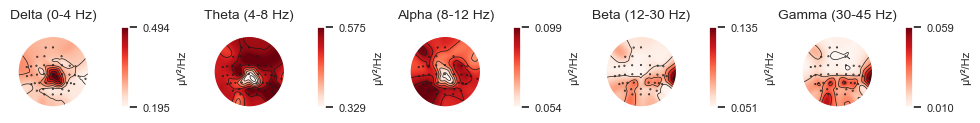

In [47]:
#for i in range(0,14):
raw_CT = raw_sig_CT[8]
raw_PD = raw_sig_PD[8]
spectrum_CT = raw_CT.compute_psd()
spectrum_PD = raw_PD.compute_psd()
spectrum_CT.plot_topomap(normalize=True)
spectrum_PD.plot_topomap(normalize=True)
#plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_AllFrec\\PD_%s_topo.jpg"%(disco,i))

In [66]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw_PD)
ica.exclude = [19]  # corresponde al numero de componentes
ica.plot_properties(raw_PD, picks=ica.exclude)

Fitting ICA to data using 39 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 2.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>]

In [13]:
##class mne.preprocessing.ICA(n_components=None, *, noise_cov=None, 
#random_state=None, method='fastica', fit_params=None, max_iter='auto', allow_ref_meg=False, verbose=None)[source]

#ICA para control
CT_ica = mne.preprocessing.ICA(random_state=42, n_components=20)
CT_ica.fit(raw_CT.copy().filter(1,None, verbose=True), verbose=False)
CT_ica.plot_components()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    0.0s finished


[<MNEFigure size 975x967 with 20 Axes>]

In [12]:
#ICA para Párkinson
PD_ica = mne.preprocessing.ICA(random_state=42, n_components=20)
PD_ica.fit(raw_PD.copy().filter(1,None, verbose=True), verbose=False)
PD_ica.plot_components()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    0.0s finished


[<MNEFigure size 975x967 with 20 Axes>]

In [16]:
#Graficarlo como imagen
def plot_eeg_topomap(signal_array, save_path_animation=None, show_names=False, start_time=0.05, end_time=1, step_size=0.1):
    # select channel X,Y format
    montage = mne.channels.make_standard_montage('standard_1020')
    
    # remove channels that don't have X,Y positions
    ch_to_remove = []
    for ch in Channels:
        if ch not in list(set(montage.ch_names).intersection(Channels)):
            ch_to_remove.append(Channels.index(ch))
    arr = np.delete(signal_array.copy(), ch_to_remove, axis=0)
    
    # create info+evoked objects
    info = mne.create_info(ch_names=list(set(montage.ch_names).intersection(Channels)), sfreq=500, ch_types='eeg')
    evoked = mne.EvokedArray(arr, info)
    
    # set channel X,Y positions
    evoked.set_montage(montage)

    # plot img
    evoked.plot_topomap(np.arange(start_time, end_time, step_size),outlines='head', ch_type='eeg', time_unit='s', ncols=5, nrows=2, show_names=show_names);

In [67]:
plot_eeg_topomap(CT_F_signal_array[8], show_names=False)

In [ ]:
plot_eeg_topomap(PD_F_signal_array[13], show_names=False)

### Gifs

In [21]:
#Plot a topographic map as an animation
def plot_eeg_topomap_animation(signal_array, save_path_animation, start_time=0.00, end_time=2, step_size=0.01, frame_rate=10):
    # select channel X,Y format
    montage = mne.channels.make_standard_montage('standard_1020')
    
    # remove channels that don't have X,Y positions
    ch_to_remove = []
    for ch in Channels:
        if ch not in list(set(montage.ch_names).intersection(Channels)):
            ch_to_remove.append(Channels.index(ch))
    arr = np.delete(signal_array.copy(), ch_to_remove, axis=0)
    
    # create info+evoked objects
    info = mne.create_info(ch_names=list(set(montage.ch_names).intersection(Channels)), sfreq=500, ch_types='eeg')
    evoked = mne.EvokedArray(arr, info)
    
    # set channel X,Y positions
    evoked.set_montage(montage)
    
    # (optional) plot and save animation
    if save_path_animation:
        fig, anim = evoked.animate_topomap(times=np.arange(start_time, end_time, step_size), frame_rate=frame_rate, butterfly=True, blit=False, );
        anim.save(save_path_animation);
        print('saved to', save_path_animation)

In [22]:
for i in range(0,14):
    plot_eeg_topomap_animation(CT_F_signal_array[i], '%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Gifs\\CT_Pat_%s.gif'%(disco,i))
    

MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_0.gif
Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_1.gif
Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_2.gif
Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_3.gif
Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_4.gif
Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_5.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_6.gif
Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_7.gif
Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_8.gif
Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_9.gif
Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_10.gif
Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_11.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...


MovieWriter ffmpeg unavailable; using Pillow instead.


saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_12.gif
Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\CT_Pat_13.gif
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...


In [23]:
for n in range(0,14):
    plot_eeg_topomap_animation(PD_F_signal_array[n], '%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Gifs\\PD_Pat_%s.gif'%(disco,n))

MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_0.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_1.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_2.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_3.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_4.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_5.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_6.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_7.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_8.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_9.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_10.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_11.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_12.gif


MovieWriter ffmpeg unavailable; using Pillow instead.


Initializing animation...
saved to E:\TFG\Data and Code (1)\Dataset\IowaDataset\Gifs\PD_Pat_13.gif
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing animation...
Initializing anim

In [38]:
%matplotlib qt

##### All signals plotted

In [28]:
for i in range(0,14):
    raw_sig_CT[i].plot(scalings='auto');
    #plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_CT_PD_allChannels\\CT_%s_allCH.jpg"%(disco,i))
    plt.show()

    raw_sig_PD[i].plot(scalings='auto');
    #plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_CT_PD_allChannels\\PD_%s_allCH.jpg"%(disco,i))
    plt.show()

Using matplotlib as 2D backend.
Channels marked as bad:
none
Attempting to create new mne-python configuration file:
C:\Users\Vaneza\.mne\mne-python.json
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [137]:
for i in range(0,14):
    raw_sig_CT[i].plot_psd();
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_PSD_CT_PD_allChannels\\CT_%s_PSD_allCH.jpg"%(disco,i))
    raw_sig_CT[i].plot_psd(average=True);
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_PSD_CT_PD_allChannels\\CT_%s_PSD_av_allCH.jpg"%(disco,i))
    plt.show()

    raw_sig_PD[i].plot_psd();
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_PSD_CT_PD_allChannels\\PD_%s_PSD_allCH.jpg"%(disco,i))
    raw_sig_PD[i].plot_psd(average=True);
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_PSD_CT_PD_allChannels\\PD_%s_PSD_av_allCH.jpg"%(disco,i))
    plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.512 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.512 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.512 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.512 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.512 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.512 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.512 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.512 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd(

#### Visualización por ondas cerebrales 

#### DELTA

In [62]:
for i in range(0,14):
    raw_filtered_CT = raw_sig_CT[i].copy().filter(1,4, verbose=False);
    raw_filtered_PD = raw_sig_PD[i].copy().filter(1,4, verbose=False);
    plt.ion() 
    raw_filtered_CT.compute_psd().plot();
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_DELTA\\CT_%s_PSD_DELTA.jpg"%(disco,i))
    raw_filtered_CT.compute_psd().plot(average=True);
    plt.xlim(0,5)
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_DELTA\\CT_%s_full_PSD_av_DELTA.jpg"%(disco,i))
    raw_filtered_CT.plot(scalings='auto')
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_DELTA\\CT_%s_allCH_DELTA.jpg"%(disco,i))
    plt.show()

    raw_filtered_PD.compute_psd().plot();
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_DELTA\\PD_%s_PSD_DELTA.jpg"%(disco,i))
    raw_filtered_PD.compute_psd().plot(average=True);
    plt.xlim(0,5)
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_DELTA\\PD_%s_full_PSD_av_DELTA.jpg"%(disco,i))
    raw_filtered_PD.plot(scalings='auto')
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_DELTA\\PD_%s_allCH_DELTA.jpg"%(disco,i))
    plt.show()


Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)


In [48]:
print(raw_filtered_CT[30][0])
print(type(raw_filtered_CT))

[[ 5.55111512e-16 -2.99830396e-01 -5.88830283e-01 ... -9.82022859e-02
  -5.18969361e-02  4.30211422e-16]]
<class 'mne.io.array.array.RawArray'>


In [49]:
raw_delta_CT_Time = pd.DataFrame(raw_filtered_CT[0][1],columns=['Time'])
Delta_signals = raw_delta_CT_Time
for i in range(0,31):
    raw_delta_CT_0_Sig = pd.DataFrame(raw_filtered_CT[i][0],index=[Channels[i]])
    Delta_signals = pd.concat([Delta_signals,raw_delta_CT_0_Sig.T],axis=1)
    
Delta_signals 

,Time,Fz,FC1,C3,T7,CP5,CP1,P3,P7,O1,...,C1,C5,TP7,CP3,P1,P5,PO7,PO3,POz,PO4
0,0.000,4.440892e-16,5.551115e-16,-2.220446e-16,4.440892e-16,-2.220446e-16,4.440892e-16,8.326673e-16,7.216450e-16,1.110223e-16,...,8.881784e-16,1.110223e-15,7.771561e-16,6.661338e-16,-3.330669e-16,8.326673e-16,2.775558e-16,0.000000e+00,-1.110223e-16,5.551115e-16
1,0.002,7.894724e-01,6.683310e-01,7.543047e-01,5.386627e-01,3.603326e-01,5.796053e-01,1.334440e-01,2.109082e-01,7.960890e-02,...,6.574394e-01,5.926717e-01,3.666547e-01,5.727219e-01,1.408432e-01,2.072101e-01,1.745181e-01,4.406191e-02,-2.980785e-02,-2.998304e-01
2,0.004,1.552081e+00,1.313430e+00,1.483195e+00,1.055661e+00,7.050302e-01,1.138140e+00,2.584170e-01,4.122066e-01,1.605976e-01,...,1.291587e+00,1.162046e+00,7.203256e-01,1.123770e+00,2.727814e-01,4.045251e-01,3.404845e-01,9.214887e-02,-5.751794e-02,-5.888303e-01
3,0.006,2.261905e+00,1.912881e+00,2.162162e+00,1.530129e+00,1.019031e+00,1.655288e+00,3.667746e-01,5.946335e-01,2.441723e-01,...,1.879978e+00,1.685680e+00,1.048460e+00,1.632254e+00,3.872567e-01,5.824082e-01,4.896372e-01,1.479465e-01,-8.114977e-02,-8.566153e-01
4,0.008,2.894885e+00,2.445884e+00,2.768471e+00,1.942770e+00,1.288402e+00,2.112216e+00,4.510199e-01,7.496171e-01,3.312297e-01,...,2.401772e+00,2.142805e+00,1.339351e+00,2.078827e+00,4.763968e-01,7.320322e-01,6.142898e-01,2.145294e-01,-9.894515e-02,-1.093648e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,119.990,-9.051420e-01,-7.097450e-01,-1.594802e+00,-6.825958e+00,-6.838995e+00,-2.020602e+00,-4.130948e+00,-5.448428e+00,-2.166795e+00,...,-1.429741e+00,-6.822369e+00,-7.228683e+00,-3.139436e+00,-3.955719e+00,-5.219234e+00,-5.613622e+00,-1.519242e+00,6.199008e-01,-1.533943e-01
59996,119.992,-6.933463e-01,-5.405575e-01,-1.225156e+00,-5.260621e+00,-5.269296e+00,-1.552181e+00,-3.201183e+00,-4.221762e+00,-1.697063e+00,...,-1.094083e+00,-5.257595e+00,-5.566143e+00,-2.418098e+00,-3.064571e+00,-4.049796e+00,-4.352478e+00,-1.213065e+00,4.649687e-01,-1.336117e-01
59997,119.994,-4.691622e-01,-3.642503e-01,-8.307405e-01,-3.575354e+00,-3.580590e+00,-1.052470e+00,-2.184092e+00,-2.880267e+00,-1.166501e+00,...,-7.398406e-01,-3.573168e+00,-3.780684e+00,-1.642736e+00,-2.090506e+00,-2.765625e+00,-2.970757e+00,-8.447739e-01,3.098729e-01,-9.820229e-02
59998,119.996,-2.366664e-01,-1.832778e-01,-4.195872e-01,-1.808373e+00,-1.810822e+00,-5.315785e-01,-1.107227e+00,-1.460118e+00,-5.939619e-01,...,-3.730717e-01,-1.807228e+00,-1.911532e+00,-8.306541e-01,-1.059672e+00,-1.402804e+00,-1.506387e+00,-4.334087e-01,1.548776e-01,-5.189694e-02


In [86]:

raw_delta_CT_0_Time = pd.DataFrame(raw_filtered_CT['PO4'][1],columns=['Time'])
raw_delta_CT_0_Sig = pd.DataFrame(raw_filtered_CT['PO4'][0],index=['PO4'])

delta_CT_0 = pd.concat([raw_delta_CT_0_Sig.T],axis=1)
#delta_CT_0 = delta_CT_0[["Time"] + CH]
delta_CT_0

,PO4
0,8.881784e-16
1,1.821820e-01
2,3.640931e-01
3,5.454720e-01
4,7.260662e-01
...,...
59995,3.361420e+00
59996,2.525054e+00
59997,1.685266e+00
59998,8.432010e-01


In [40]:
## Plot of CT patients 
fig = plt.subplots(1,1,figsize=(20,10))

plt.plot(delta_CT_0['Time'], delta_CT_0['PO4'], label='Delta PO4')
plt.legend(loc='upper right')
plt.ylabel("Amplitud")
plt.xlabel("Time(ms)")
plt.xlim(0,120)
plt.show()

Channels marked as bad:
none


#### THETA

In [72]:
for i in range(0,14):
    raw_filtered_CT = raw_sig_CT[i].copy().filter(4,8, verbose=False);
    raw_filtered_PD = raw_sig_PD[i].copy().filter(4,8, verbose=False);
    plt.ion() 
    raw_filtered_CT.compute_psd().plot();
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_THETA\\CT_%s_PSD_THETA.jpg"%(disco,i))
    raw_filtered_CT.compute_psd().plot(average=True);
    plt.title('CT%s_PSDav_THETA'%(i))
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_THETA\\CT_%s_full_PSD_av_THETA.jpg"%(disco,i))
    raw_filtered_CT.compute_psd().plot(average=True);
    plt.xlim(3,9)
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_THETA\\CT_%s_PSD_av_THETA.jpg"%(disco,i))
    raw_filtered_CT.plot(scalings='auto')
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_THETA\\CT_%s_allCH_THETA.jpg"%(disco,i))
    plt.show()

    raw_filtered_PD.compute_psd().plot();
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_THETA\\PD_%s_PSD_THETA.jpg"%(disco,i))
    raw_filtered_PD.compute_psd().plot(average=True);
    plt.title('PD%s_PSDav_THETA'%(i))
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_THETA\\PD_%s_full_PSD_av_THETA.jpg"%(disco,i))
    raw_filtered_PD.compute_psd().plot(average=True);
    plt.xlim(3,9)
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_THETA\\PD_%s_PSD_av_THETA.jpg"%(disco,i))
    raw_filtered_PD.plot(scalings='auto')
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_THETA\\PD_%s_allCH_THETA.jpg"%(disco,i))
    plt.show()


Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)


#### ALPHA

In [76]:
for i in range(0,14):
    raw_filtered_CT = raw_sig_CT[i].copy().filter(8,15, verbose=False);
    raw_filtered_PD = raw_sig_PD[i].copy().filter(8,15, verbose=False);
    plt.ion() 
    raw_filtered_CT.compute_psd().plot();
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_ALPHA\\CT_%s_PSD_ALPHA.jpg"%(disco,i))
    raw_filtered_CT.compute_psd().plot(average=True);
    plt.title('CT%s_PSDav_ALPHA'%(i))
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_ALPHA\\CT_%s_full_PSD_av_ALPHA.jpg"%(disco,i))
    raw_filtered_CT.compute_psd().plot(average=True);
    plt.xlim(7,16)
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_ALPHA\\CT_%s_PSD_av_ALPHA.jpg"%(disco,i))
    raw_filtered_CT.plot(scalings='auto')
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_ALPHA\\CT_%s_allCH_ALPHA.jpg"%(disco,i))
    plt.show()

    raw_filtered_PD.compute_psd().plot();
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_ALPHA\\PD_%s_PSD_ALPHA.jpg"%(disco,i))
    raw_filtered_PD.compute_psd().plot(average=True);
    plt.title('PD%s_PSDav_ALPHA'%(i))
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_ALPHA\\PD_%s_full_PSD_av_ALPHA.jpg"%(disco,i))
    raw_filtered_PD.compute_psd().plot(average=True);
    plt.xlim(7,16)
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_ALPHA\\PD_%s_PSD_av_ALPHA.jpg"%(disco,i))
    raw_filtered_PD.plot(scalings='auto')
    plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_ALPHA\\PD_%s_allCH_ALPHA.jpg"%(disco,i))
    plt.show()
    

Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)


#### BETA

In [79]:
for i in range(0,14):
    raw_filtered_CT = raw_sig_CT[i].copy().filter(15,32, verbose=False);
    raw_filtered_PD = raw_sig_PD[i].copy().filter(15,32, verbose=False);
    plt.ion() 
    # raw_filtered_CT.compute_psd().plot();
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_BETA\\CT_%s_PSD_BETA.jpg"%(disco,i))
    # raw_filtered_CT.compute_psd().plot(average=True);
    # plt.title('CT%s_PSDav_BETA'%(i))
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_BETA\\CT_%s_full_PSD_av_BETA.jpg"%(disco,i))
    raw_filtered_CT.compute_psd().plot(average=True);
    plt.xlim(14,33)
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_BETA\\CT_%s_PSD_av_BETA.jpg"%(disco,i))
    # raw_filtered_CT.plot(scalings='auto')
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_BETA\\CT_%s_allCH_BETA.jpg"%(disco,i))
    # plt.show()

    # raw_filtered_PD.compute_psd().plot();
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_BETA\\PD_%s_PSD_BETA.jpg"%(disco,i))
    # raw_filtered_PD.compute_psd().plot(average=True);
    # plt.title('PD%s_PSDav_BETA'%(i))
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_BETA\\PD_%s_full_PSD_av_BETA.jpg"%(disco,i))
    raw_filtered_PD.compute_psd().plot(average=True);
    plt.xlim(14,33)
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_BETA\\PD_%s_PSD_av_BETA.jpg"%(disco,i))
    # raw_filtered_PD.plot(scalings='auto')
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_BETA\\PD_%s_allCH_BETA.jpg"%(disco,i))
    # plt.show()
    

Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)


#### GAMMA

In [83]:
for i in range(0,14):
    raw_filtered_CT = raw_sig_CT[i].copy().filter(32,100, verbose=False);
    raw_filtered_PD = raw_sig_PD[i].copy().filter(32,100, verbose=False);
    plt.ion() 
    # raw_filtered_CT.compute_psd().plot();
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_GAMMA\\CT_%s_PSD_GAMMA.jpg"%(disco,i))
    # raw_filtered_CT.compute_psd().plot(average=True);
    # plt.title('CT%s_PSDav_GAMMA'%(i))
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_GAMMA\\CT_%s_full_PSD_av_GAMMA.jpg"%(disco,i))
    raw_filtered_CT.compute_psd().plot(average=True);
    plt.xlim(31,101)
    # plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_GAMMA\\CT_%s_PSD_av_GAMMA.jpg"%(disco,i))
    # raw_filtered_CT.plot(scalings='auto')
#     plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_GAMMA\\CT_%s_allCH_GAMMA.jpg"%(disco,i))
#     plt.show()

#     raw_filtered_PD.compute_psd().plot();
#     plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_GAMMA\\PD_%s_PSD_GAMMA.jpg"%(disco,i))
#     raw_filtered_PD.compute_psd().plot(average=True);
#     plt.title('PD%s_PSDav_GAMMA'%(i))
#     plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_GAMMA\\PD_%s_full_PSD_av_GAMMA.jpg"%(disco,i))
    raw_filtered_PD.compute_psd().plot(average=True);
    plt.xlim(31,101)
#     plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_GAMMA\\PD_%s_PSD_av_GAMMA.jpg"%(disco,i))
    # raw_filtered_PD.plot(scalings='auto')
#     plt.savefig("%s:\\TFG\\Data and Code (1)\\Dataset\\IowaDataset\\Plots_GAMMA\\PD_%s_allCH_GAMMA.jpg"%(disco,i))
#     plt.show()

Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
Effective window size : 0.512 (s)
